In [1]:
import numpy as np
from IPython.display import Image,display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The 1D Korteweg-de Vries (KdV) / Burgers equation is a hybrid equation combining features from the KdV equation used in fluid dynamics and wave propagation, and the Burgers equation which deals with phenomena like shock waves and turbulence. The KdV/Burgers equation can be represented in Markdown as follows:

```
∂u/∂t + u*(∂u/∂x) - ν*(∂²u/∂x²) + (3*a*ν)*(∂³u/∂x³) = 0
```
```latex
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} + (3a\nu) \frac{\partial^3 u}{\partial x^3} = 0
```
Where:

- `u` is the dependent variable representing velocity or some other physical quantity.
- `t` is time.
- `x` is the spatial coordinate.
- `ν` is kinematic viscosity or diffusion coefficient.
- `a` represents a coefficient of the third-order derivative term.

This equation represents the balance between nonlinear advection, second-order diffusion or dissipation, and third-order dispersion in one-dimensional systems. It has been employed to study various physical phenomena, including water waves, plasma physics, and traffic flow.

2023-04-26 17:24:56,343 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
2023-04-26 17:24:57,138 __main__ 0/1 INFO :: Iteration=100, Time=2.000000e-01, dt=2.000000e-03
2023-04-26 17:24:57,196 __main__ 0/1 INFO :: Iteration=200, Time=4.000000e-01, dt=2.000000e-03
2023-04-26 17:24:57,251 __main__ 0/1 INFO :: Iteration=300, Time=6.000000e-01, dt=2.000000e-03
2023-04-26 17:24:57,311 __main__ 0/1 INFO :: Iteration=400, Time=8.000000e-01, dt=2.000000e-03
2023-04-26 17:24:57,364 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03
2023-04-26 17:24:57,429 __main__ 0/1 INFO :: Iteration=600, Time=1.200000e+00, dt=2.000000e-03
2023-04-26 17:24:57,486 __main__ 0/1 INFO :: Iteration=700, Time=1.400000e+00, dt=2.000000e-03
2023-04-26 17:24:57,544 __main__ 0/1 INFO :: Iteration=800, Time=1.600000e+00, dt=2.000000e-03
2023-04-26 17:24:57,601 __main__ 0/1 INFO :: Iteration=900, Time=1.800000e+00, dt=2.000000e-03
2023-04-26 17

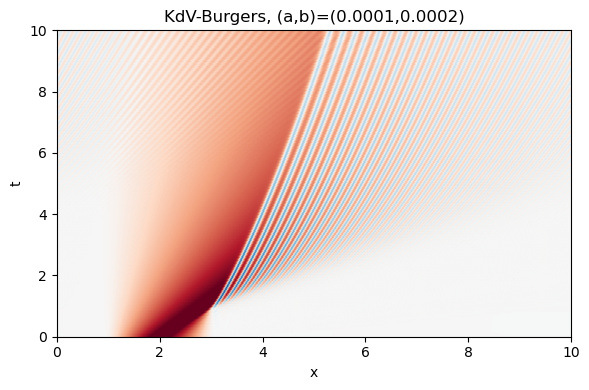

In [2]:
"""
Dedalus script simulating the 1D Korteweg-de Vries / Burgers equation.
This script demonstrates solving a 1D initial value problem and produces
a space-time plot of the solution. It should take just a few seconds to
run (serial only).

We use a Fourier basis to solve the IVP:
    dt(u) + u*dx(u) = a*dx(dx(u)) + b*dx(dx(dx(u)))

To run and plot:
    $ python3 kdv_burgers.py
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx = 10  #size of domain
Nx = 1024 #no of points in mesh
a = 1e-4
b = 2e-4
dealias = 3/2
stop_sim_time = 10
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=xbasis)

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) - a*dx(dx(u)) - b*dx(dx(dx(u))) = - u*dx(u)")

# Initial conditions
x = dist.local_grid(xbasis)
n = 20
u['g'] = np.log(1 + np.cosh(n)**2/np.cosh(n*(x-0.2*Lx))**2) / (2*n)

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-0.8, 0.8))
plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'KdV-Burgers, (a,b)=({a},{b})')
plt.tight_layout()
plt.savefig('kdv_burgers.pdf')
plt.savefig('kdv_burgers.png', dpi=200)



In [62]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import os
logger = logging.getLogger(__name__)


# Parameters
Lx = 10  #size of domain
Nx = 1024 #no of points in mesh
c = 1 #the wave speed
dealias = 3/2
stop_sim_time = 15
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Chebyshev(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

# Fields
u = dist.Field(name='u', bases=xbasis)
v = dist.Field(name='v', bases=xbasis)

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)

# Problem
problem = d3.IVP([u,v], namespace=locals())
problem.add_equation("dt(u) - v = 0")
problem.add_equation("dt(v) - c**2 * dx(dx(u)) = 0")
problem.add_bc("left(u) = 0") # u(0)=0
problem.add_bc("right(u) = 0") # u(Lx)=0

# Initial conditions
x_0 = Lx/2
sigma = np.sqrt(1e-2)
x = dist.local_grid(xbasis)
u['g'] = np.exp(-((x-x_0)**2)/(2*(sigma**2)))
v['g'] = np.zeros_like(dist.local_grid(xbasis))

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
v.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 100 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        v.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)


AttributeError: module 'dedalus.public' has no attribute 'ParsedProblem'

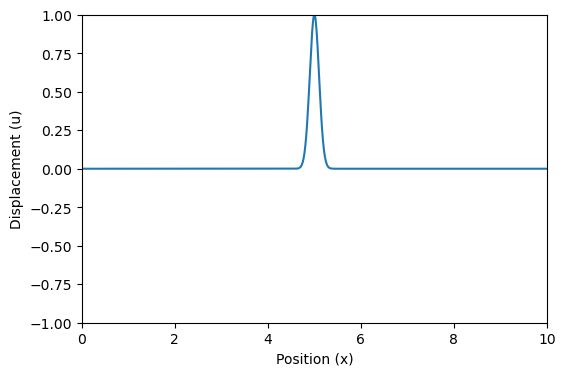

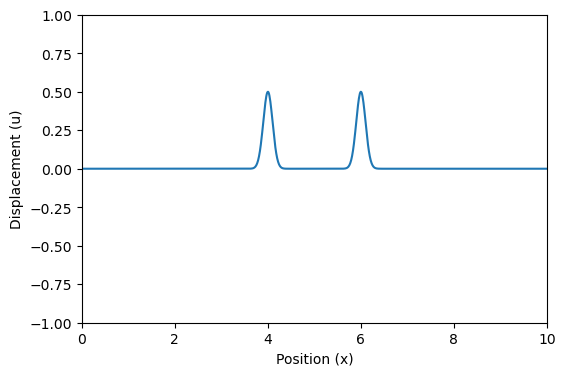

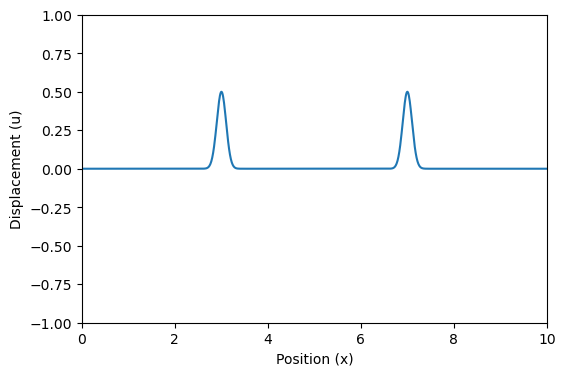

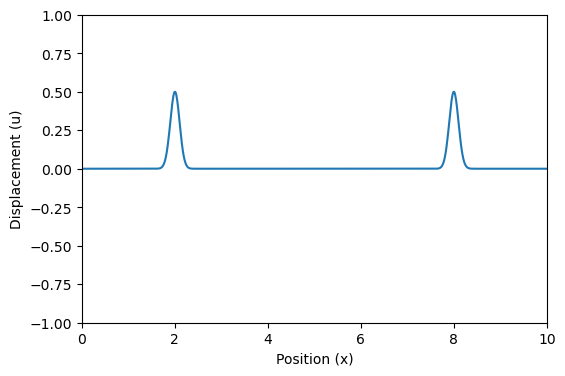

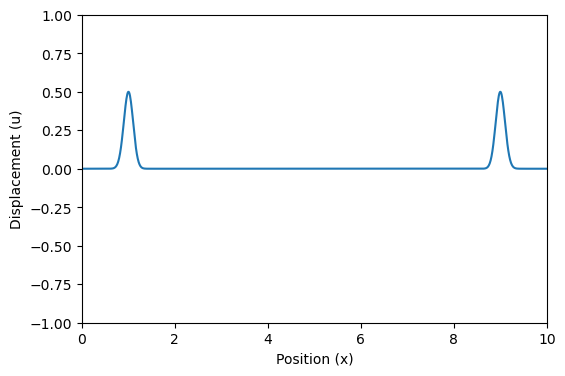

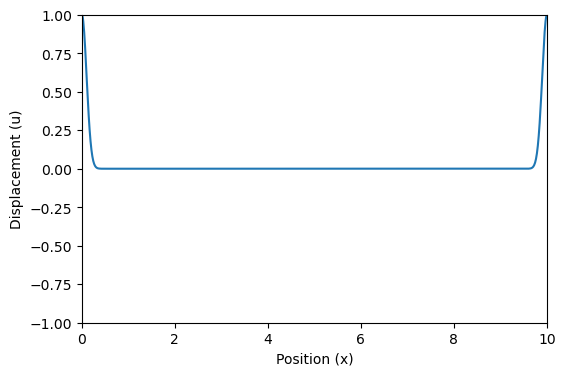

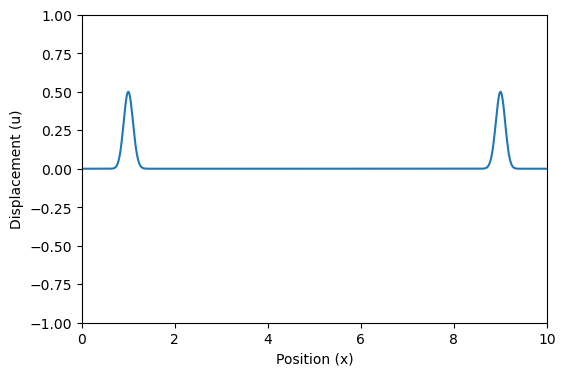

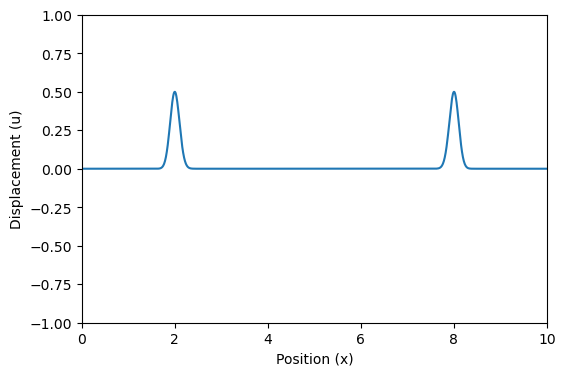

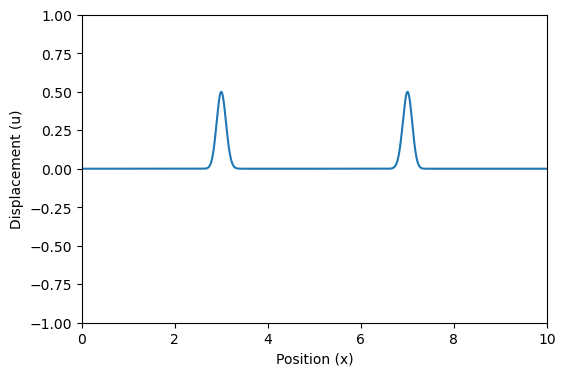

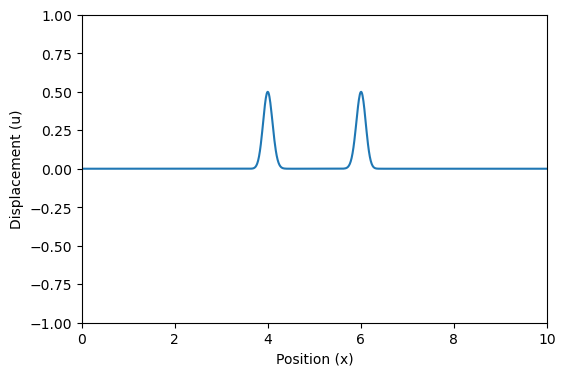

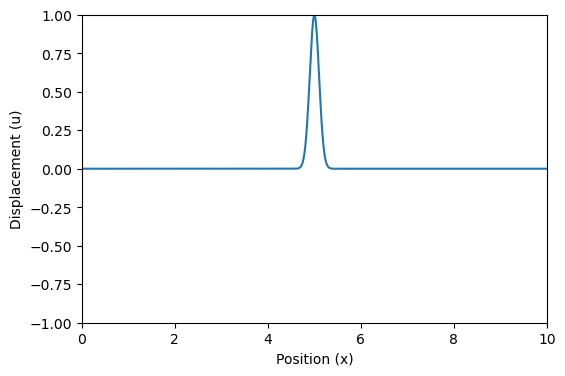

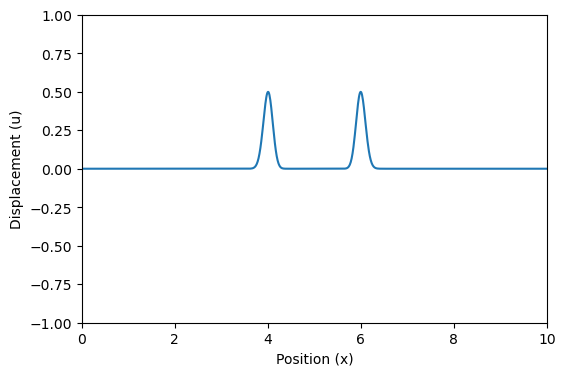

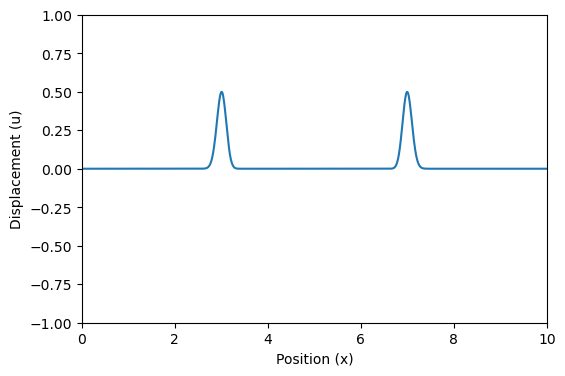

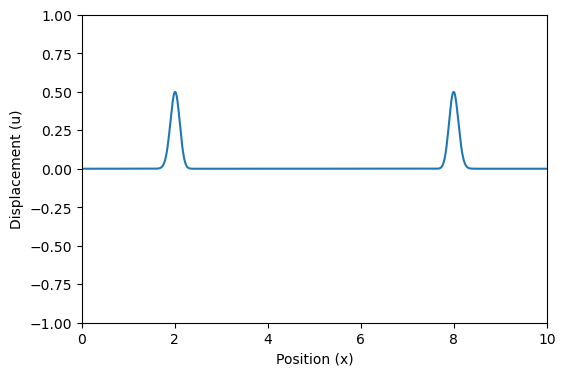

In [57]:
#Plot
num = 15

for i in range(num):
    plt.figure(figsize=(6, 4))

    index = int(i * len(u_list) / num)

    plt.plot(x.ravel(), u_list[index])
    plt.ylim(-, np.max(u_list))
    plt.xlim(0, Lx)
    plt.xlabel('Position (x)')
    plt.ylabel('Displacement (u)')

plt.close()